# Melanoma Detection Assignment

---
<p align = 'right'>Completed By Prayag Sanjay in May 2022</p>

## Problem Statment

To build a CNN based model which can accurately detect melanoma. 

Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths.

A machine learning solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


## Goal of Assignment

**To build a multiclass classification model using a custom convolutional neural network in TensorFlow.**



## Approach

We will build a baseline CNN model first and tune it on the validation set.

We will check for underfitting / overfitting of  model and improve it using **Augmentation** of the training data.

We will check for **class imbalance** of the  model and improve it generating more images of each class.


### Importing all the libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation

### Importing Skin Cancer Data


#### If data is in google drive and running under Colab, use following code

In [2]:
## If data is on a Google mount the Google drive

# drive.mount('/content/gdrive')


## IMPORTANT !

### It is assumed that data is extracted in same directory as the notebook without any change to folder name
### i.e. data resides in a folder called 'Skin cancer ISIC The International Skin Imaging Collaboration' in the **same** directory as the notebook


In [3]:
# Defining the directory path for train and test images

data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
# find the count the images under train and test directories

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Count of images in train directory:", image_count_train)

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Count of images in test directory:" , image_count_test)

Count of images in train directory: 2239
Count of images in test directory: 118


**Observation:**


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Create a train and validation dataset

Define some parameters for the loader and model building

In [5]:
# define parameters

batch_size = 32
img_height = 180
img_width = 180

**We will use 80% of the images for training, and 20% for validation.**

In [6]:
# load the train dataset
# we will use 80:20 split for test and validation

train_ds = image_dataset_from_directory(data_dir_train,
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        validation_split = 0.2,
                                        subset = 'training',
                                        image_size=(img_height, img_width),
                                        shuffle=True,
                                        seed=123
                                       )
 

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# laod the validation dataset

val_ds = image_dataset_from_directory(data_dir_train,
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        validation_split = 0.2,
                                        subset = 'validation',                                      
                                        image_size=(img_height, img_width),
                                        shuffle=True,
                                        seed=123
                                       )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

#### We will visualize one instance of all the nine classes present in the dataset

In [9]:
# create two numpy arrays of labels and images from first two batches of dataset

labels_np = np.empty(shape=(0,), dtype=np.int32)
images_np = np.empty(shape=(0, 180, 180, 3), dtype=np.float32)
for images, labels in train_ds.take(4):
    labels_np = np.hstack((labels_np, labels.numpy()))
    images_np = np.vstack((images_np, images.numpy()))


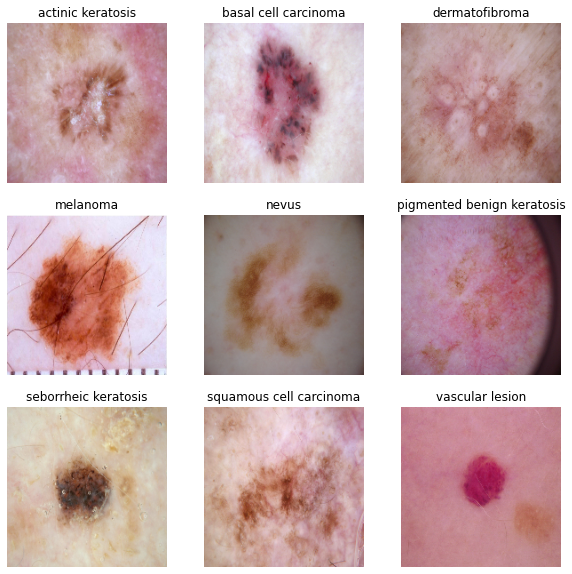

In [10]:
# show one random image for each class of the data

fig = plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    label_idx = np.where(labels_np[:]==i)[0]
    img_num = label_idx[np.random.randint(label_idx.shape[0])]
    plt.imshow(images_np[img_num].astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")
        
plt.show()              

### Configure the dataset for performance

Let's make sure to use buffered prefetching so the we can yield data from disk without having I/O become blocking. These are two important methods that we will use:

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
# set up dataset cache and set prefetch

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the the baseline CNN model

We will create a baseline CNN model without regularisation or optimisation

Model will have 4 convolutional units having a convolutional layers followed by max pooling layer

This will be followed by flattening layer and fully connected layer.


In [12]:
# define the layer of CNN model

model = keras.Sequential()

# a normalisation layer to scale the RGB value to 0 and 1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))),

# first convolutional layer
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

# 2nd convolutional layer
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

# 3rd convolutional layer
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

# 4th convolutional layer
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# the output layer
model.add(Dense(len(class_names)))

In [13]:
# show the summary information of the model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**Observation**

By using the pooling layer after each convolutional layer, we have done **downsampling** thus keeping the model
complexity and number of trainable parameters low.

### Compile the model

We have chosen **Adam** optimiser and **SparseCategoricalCrossentropy** loss function for model training.

Adam optimiser has been found to give optimum results on image classification problems of this type.

SparseCategoricalCrossentropy is chosen because the target label is a single scalar value and is not one hotencoded.

In [14]:
# compile the model

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

### Train the model

In [15]:
# we will the tain model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 45s 687ms/step - loss: 2.0066 - accuracy: 0.2372 - val_loss: 1.9615 - val_accuracy: 0.2282
Epoch 2/20
56/56 [==============================] - 37s 662ms/step - loss: 1.8256 - accuracy: 0.3276 - val_loss: 1.7590 - val_accuracy: 0.3758
Epoch 3/20
56/56 [==============================] - 35s 626ms/step - loss: 1.6092 - accuracy: 0.4263 - val_loss: 1.5225 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 36s 640ms/step - loss: 1.4915 - accuracy: 0.4648 - val_loss: 1.5030 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 32s 577ms/step - loss: 1.4099 - accuracy: 0.4983 - val_loss: 1.4391 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 35s 627ms/step - loss: 1.2982 - accuracy: 0.5296 - val_loss: 1.3937 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 34s 615ms/step - loss: 1.2695 - accuracy: 0.5541 - val_loss: 1.3750 - val_accuracy: 0.5213

### Visualizing training results

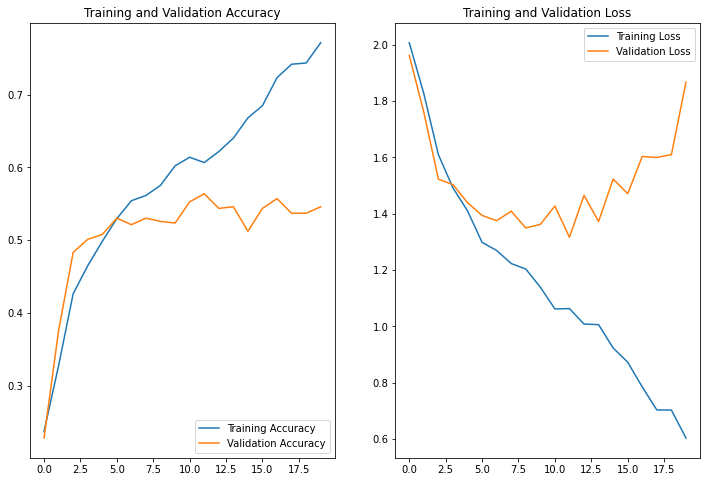

In [16]:
# we will plot the training and validation accuracy and loss plots to see whether there is underfitting or overfitting

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations / Findings

1. The training accuracy is increasing linearly over time, whereas validation accuracy stalls around 55% in the training process.


2. We can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 55% accuracy on the validation set while it 80% accuracy on the training set.


3. Similarly we can see the validation loss decerases first and then it stops decreasing while training loss goes on decreasing.


4. This difference in accuracy between training and validation accuracy is noticeable sign of **Overfitting**


5. The reason for overfitting is most likely the small number of training examples. As a result the model sometimes learns from noises or unwanted details from training examples to an extent that it negatively impacts the performance of the model on new examples. Thus the model is not available to generalise well on the new obervations.


### Strategy to overcome the overfitting


1. There are multiple ways to fight overfitting in the training process. In this assignment we will use  **data augmentation** and adding **Dropout** to the model.


2. Data augmentation generates additional training data from existing examples by augmenting them using random transformations that yield believable looking images.


3. Data augmentation is appropriate strategy as in this case overfitting has occured as there is a small number of training examples.


4. This helps expose the model to more aspects of the data and generalize better.




### We will implement data augmentation using experimental Keras Preprocessing Layers 

We will generate new images by **rotating**, **flipping** and **zooming** random images.

In [17]:
# define the data augementation pipeline

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
  ]
)

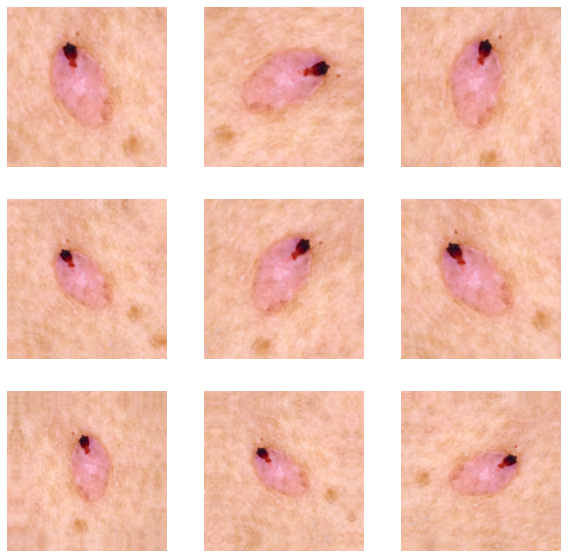

In [18]:
# To visualize augmentation strategy we will visualise one  instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Create the model, compile and train the model using Augmentation strategy

Model will have 4 convolutional units having a convolutional layers followed by max pooling layer

This will be followed by flattening layer and fully connected layer.

We also add a dropout of 0.2 to reduce overfitting.

In [19]:
# define the layer of CNN model

model = keras.Sequential()

# add augmentation of the layer
model.add(data_augmentation)

# a normalisation layer to scale the RGB value to 0 and 1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))),

# first convolutional layer
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

# 2nd convolutional layer
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

# 3rd convolutional layer
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

# 4th convolutional layer
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

# we will try to reduce overfitting by adding dropout
model.add(Dropout(0.2))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# the output layer
model.add(Dense(len(class_names)))

In [20]:
# show the summary of the model

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Compiling the model

In [21]:
# compile the model

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

### Training the model

In [22]:
## We will train the model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 43s 752ms/step - loss: 2.0152 - accuracy: 0.2210 - val_loss: 1.8972 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - 39s 699ms/step - loss: 1.8054 - accuracy: 0.3432 - val_loss: 1.6332 - val_accuracy: 0.4139
Epoch 3/20
56/56 [==============================] - 38s 682ms/step - loss: 1.6557 - accuracy: 0.3973 - val_loss: 1.6069 - val_accuracy: 0.4519
Epoch 4/20
56/56 [==============================] - 39s 692ms/step - loss: 1.5949 - accuracy: 0.4174 - val_loss: 1.6744 - val_accuracy: 0.3669
Epoch 5/20
56/56 [==============================] - 38s 680ms/step - loss: 1.5666 - accuracy: 0.4459 - val_loss: 1.5420 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 39s 696ms/step - loss: 1.5152 - accuracy: 0.4526 - val_loss: 1.5653 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 40s 720ms/step - loss: 1.4627 - accuracy: 0.4788 - val_loss: 1.4337 - val_accuracy: 0.4743

### Visualizing the results

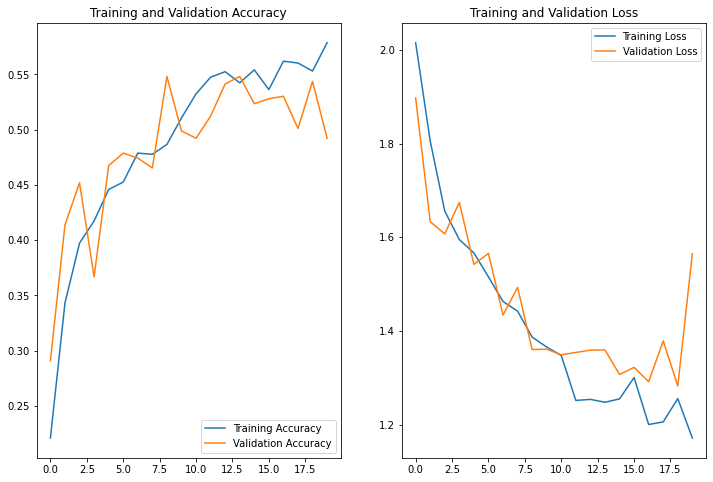

In [23]:
# we will plot the training and validation accuracy and loss plots to see whether data augementation has reduced overfitting or not

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

**Obversations**

1. Though **Accuracy** is still around 55%, it is same for both training and validation sets.


2. After applying data augmentation and Dropout, there is less overfitting than before  as training and validation accuracy are closer than before. The accuracy for both training and validation decrease gradually together.


3. The loss for both training and validation decrease gradually together.


4. This shows that applying **Augmentation** has solved the issue of overfitting to some extent. 



## Check for the class imbalance

We will check for the class imbalance in our model as Class imbalance can have a detrimental effect on the final model quality. 


In [24]:
## a list of path of files in the training directory

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [25]:
# get a list of the names (labels) of various cancerous conditions

lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [26]:
# build a dictorary of  path and labels

dataframe_dict = dict(zip(path_list, lesion_list))

In [27]:
# create dataframe of the above dictionary

original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [28]:
# find the count of various cases cancerous conditions

original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

<AxesSubplot:>

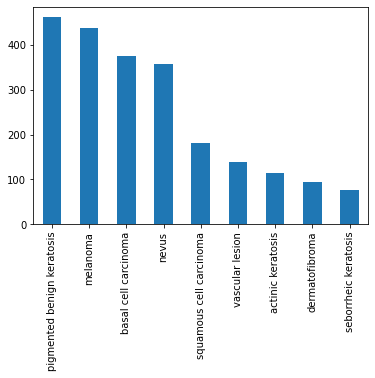

In [29]:
# show the distribution of the number of images for each label

original_df['Label'].value_counts().plot(kind='bar')

#### Observations

1. We can see from the above plot that number of images in 'seborrheic keratosis' class is less than 100 and is the least. Same is true from classes 'vascular lesion', 'actinic keratosis' and 'dermatofibronoma'.


2. Number of images in 'pigmented begnigh keratosis' is maxmimum and same is true for classses 'melanoma' and 'basal cell carcinoma' and 'nevus'. These classes **dominate the data in terms proportionate number of samples**.


3. So we can see that there is group of classes which dominate the sample, and there is group of classes which do not so.


4. So we can conclude that there is **Class Imabalance** in the dataset. Class imbalance can have a detrimental effect on the final model quality. 


###  Rectifying the class imbalance


We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
# install Augmentor is necessary

#!pip install Augmentor

In [31]:
# To use `Augmentor`, the following general procedure is followed:

# 1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.
# 2. Define a number of operations to perform on this data set using your `Pipeline` object.
# 3. Execute these operations by calling the `Pipeline’s` `sample()` method.


path_to_training_dataset=data_dir_train
import Augmentor

for i in class_names :
    # define the pipeline
    p = Augmentor.Pipeline(str(path_to_training_dataset) + '/' + i)
    
    # apply various transformations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    p.sample(500) 

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x265223E0520>:   1%| | 7/500 [00:00<01:14

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26529E053A0>: 100%|█| 500/500 [00:06<00:00, 74.53 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2651AACEAC0>: 100%|█| 500/500 [00:06<00:00, 71.48 Samples/
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x265298AFA60>:   2%| | 8/500 [00:00<01:16,  6.41 Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x26521FB3220>: 100%|█| 500/500 [00:06<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x26521A51820>: 100%|█| 500/500 [00:38<00:00, 12.88 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x2652066BCD0>: 100%|█| 500/500 [00:35<00:00, 14.16 Samples/
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x265222A4910>:   1%| | 3/500 [00:00<01:22,  6.06 Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2652235EFD0>: 100%|█| 500/500 [00:06<00:00, 75.53 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x265218954C0>: 100%|█| 500/500 [00:16<00:00, 31.14 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26521FDCCD0>: 100%|█| 500/500 [00:07<00:00, 70.93 Samples/
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x265206303A0>:   0%| | 1/500 [00:00<01:25,  5.81 Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x26521FF6220>: 100%|█| 500/500 [00:07<00:


Augmentor will store the augmented images in the output sub-directory of each of the sub-directories of skin cancer types

In [32]:
# find the count of image after adding above

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Find the distribution of augmented data after adding new images to the original training data.

In [33]:
## a list of path of files in the training directory having agumented images as well

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new

In [34]:
## a list of path of files in the training directory

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [35]:
# build a dictorary of  path and labels

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
# create dataframe of the above dictionary

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [37]:
# find the count of various cases cancerous conditions

new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

<AxesSubplot:>

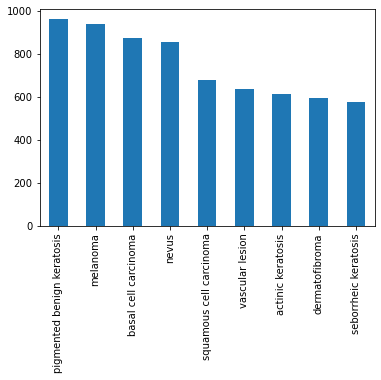

In [38]:
# show the distribution of the number of images for each label after adding more images

new_df['Label'].value_counts().plot(kind='bar')

#### Observations

We can see from the above plot that number of images each of the classes are more or less the same. Thus we can say that 
**classes are no longer imblanced**.


### Create the model, compile and train the model after addressing class imbalance

####  Create a training dataset

We will create the traning dataset again, this time it will include additional images created in steps above.

In [39]:
# load the train dataset
# we will use 80:20 split for test and validation

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [40]:
# load the validation dataset
# we will use 80:20 split for test and validation

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create the the  CNN model

We will create a CNN model

Model will have 5 convolutional units having a convolutional layer followed by max pooling layer
We have put on extra layer to have greater accuracy.

We will include BatchNormalisation to reduce overfitting.

This will be followed by flattening layer and fully connected layer.

We also include **dropout** layer to address the issue overfitting.

In [41]:
# define the layer of CNN model

model = keras.Sequential()

# a normalisation layer to scale the RGB value to 0 and 1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))),

# first convolutional layer
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization()),

# 2nd convolutional layer
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization()),

# 3rd convolutional layer
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization()),

# 4th convolutional layer
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization()),

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization()),

model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))
# add dropout to reduce overfitting
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

# the output layer
model.add(Dense(len(class_names)))


In [42]:
## get summary of the model

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 32)      

### Compile the model

We have chosen **Adam** optimiser and **SparseCategoricalCrossentropy** loss function for model training.

Adam optimiser have been found to give optimum results on image classification problems of this time.

SparseCategoricalCrossentropy is chosen because the target label is a single scalar value and is not one hotencoded.

We kept a low learning of 0.0001 as we earlier observed that validation accuracy was fluctuating wildly

In [43]:
# compile the model
# we kept a low learning as we earlier observed that validation accuracy was fluctuating wildly

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

### Train the model

In [44]:
## We will train the model for 30 epochs
## We training for more epochs to achieve greater accuracy

epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
169/169 [==============================] - 120s 703ms/step - loss: 1.7391 - accuracy: 0.3748 - val_loss: 2.1785 - val_accuracy: 0.1188
Epoch 2/30
169/169 [==============================] - 124s 733ms/step - loss: 1.2246 - accuracy: 0.5480 - val_loss: 1.9410 - val_accuracy: 0.2183
Epoch 3/30
169/169 [==============================] - 131s 774ms/step - loss: 0.9719 - accuracy: 0.6482 - val_loss: 1.3220 - val_accuracy: 0.5278
Epoch 4/30
169/169 [==============================] - 121s 715ms/step - loss: 0.8169 - accuracy: 0.7162 - val_loss: 0.9805 - val_accuracy: 0.6488
Epoch 5/30
169/169 [==============================] - 126s 745ms/step - loss: 0.6817 - accuracy: 0.7639 - val_loss: 0.7233 - val_accuracy: 0.7543
Epoch 6/30
169/169 [==============================] - 123s 720ms/step - loss: 0.5937 - accuracy: 0.7912 - val_loss: 0.8319 - val_accuracy: 0.7209
Epoch 7/30
169/169 [==============================] - 123s 724ms/step - loss: 0.4906 - accuracy: 0.8325 - val_loss: 0.8528 -

### Visualizing training results

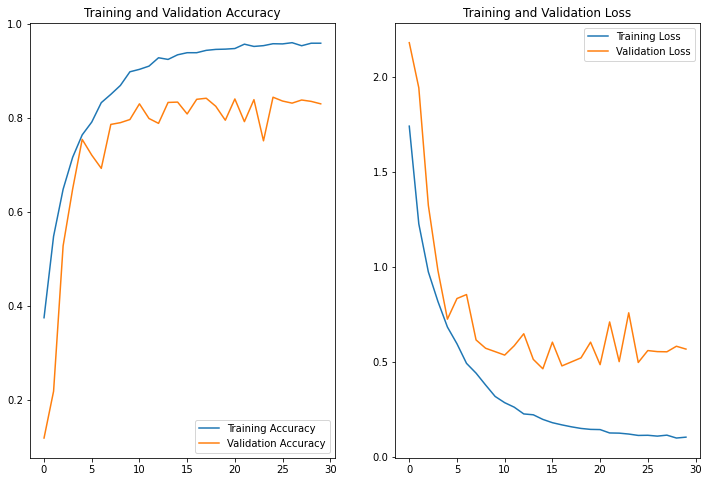

In [46]:
# we will plot the training and validation accuracy and loss plots to see whether there is underfitting or overfitting

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Obversations**

1. The model has achieved a validation accuracy of 85% **which is an improvement over the previous models by 30%.**


2. There is less overfitting than before  as training and validation accuracy are closer than before. The accuracy for both training and validation decrease gradually together.


3. The loss for both training and validation decrease gradually together as well.


4. So we can conclude the **after reducing class imbalance**, tuning the learning rate, the **accuracy has increases significantly** and also **overfitting is under check** as well.


5. So overall we can conclude that for a case where the number of training data is less, following needs to be employed.

   
   **Adding more data using augementation pipeline**


   **Adding dropout layer to reduce overfitting**
   
   
   **Adding more layer to achieve more accuracy**
   
   
   **Tune learning rate for optimum accuracy**

